A SOLAR COMPANY HAS APPROACHED US WITH THE PROBLEM : THEY REQUIRE TO MAKE FORECASTS ON THEIR DAILY YIELDS BASED OFF THE PREVIOUS 

YIELDS. GIVEN THEIR DATA I WILL GENERATE FUTURISTIC PREDICTIONS USING DEEP LEARING AND RNNS 

In [1]:
# importing the necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
df = pd.read_csv("C:\\Datasets\\Solar Power\\Plant_1_Generation_Data.csv")
df_original = df.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [4]:
df.shape

(68778, 7)

In [5]:
df.describe()

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,68778.0,68778.000000,68778.000000,68778.000000,6.877800e+04
mean,4135001.0,3147.426211,307.802752,3295.968737,6.978712e+06
std,0.0,4036.457169,394.396439,3145.178309,4.162720e+05
min,4135001.0,0.000000,0.000000,0.000000,6.183645e+06
25%,4135001.0,0.000000,0.000000,0.000000,6.512003e+06
50%,4135001.0,429.000000,41.493750,2658.714286,7.146685e+06
75%,4135001.0,6366.964286,623.618750,6274.000000,7.268706e+06
max,4135001.0,14471.125000,1410.950000,9163.000000,7.846821e+06


In [6]:
df.isnull().sum()

DATE_TIME      0
PLANT_ID       0
SOURCE_KEY     0
DC_POWER       0
AC_POWER       0
DAILY_YIELD    0
TOTAL_YIELD    0
dtype: int64

In [7]:
import datetime
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

In [8]:
df.dtypes

DATE_TIME      datetime64[ns]
PLANT_ID                int64
SOURCE_KEY             object
DC_POWER              float64
AC_POWER              float64
DAILY_YIELD           float64
TOTAL_YIELD           float64
dtype: object

In [9]:
df.drop(['SOURCE_KEY','PLANT_ID'],axis=1,inplace=True)

In [10]:
# renaming the columns to lower case letters
df= df.rename(columns={'DATE_TIME':'year','SOURCE_KEY':'source_key','DC_POWER':'dc_power',
                        'AC_POWER':'ac_power','DAILY_YIELD':'daily_yield','TOTAL_YIELD':'total_yield'
            })

In [11]:
df.columns

Index(['year', 'dc_power', 'ac_power', 'daily_yield', 'total_yield'], dtype='object')

In [12]:
def  trend_overtime(column,color,date=df['year'],df=df):
    """This function aims at plotting the relationships between variable over time,the comparisons will provide some
    insight over the yields ,and it involves data visualization using seaborn and matplotlib
    
    Args:
    column1 - the column we wish to analyse
    df : DataFrame that we are studying 
    Returns : 
    plots and visualizations]
    """
    fig = plt.figure(figsize=(20,8))
    sns.lineplot(x=column,color=color,data=df)
    plt.title(f'The distribution of {column} overtime')
    plt.show()
    

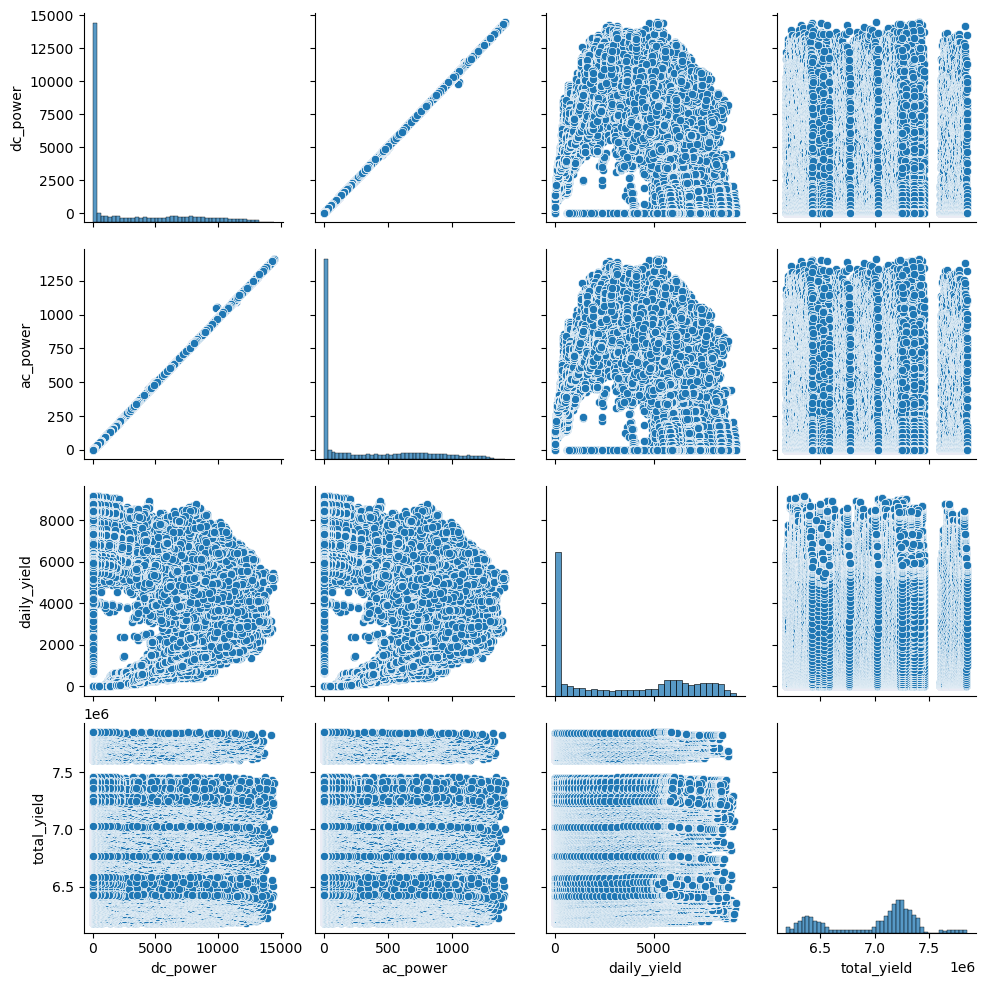

In [13]:
sns.pairplot(df)
plt.show()
# The pairplot indicates that a linear relationship cannot be easily concluded

In [14]:
# Checking for  correlation between our variables
correlation = df.corr()
correlation # The total yield has correlations with the ac_power ,dc_power and so we can model a linear regression

,dc_power,ac_power,daily_yield,total_yield
dc_power,1.000000,0.999996,0.082284,0.003815
ac_power,0.999996,1.000000,0.082234,0.003804
daily_yield,0.082284,0.082234,1.000000,0.009867
total_yield,0.003815,0.003804,0.009867,1.000000


In [15]:
# Building on the intuition of CORRELATION how about R Squared
r_squared = correlation**2
r_squared # The R squared isnt that high for any of the variables

,dc_power,ac_power,daily_yield,total_yield
dc_power,1.000000,0.999993,0.006771,0.000015
ac_power,0.999993,1.000000,0.006763,0.000014
daily_yield,0.006771,0.006763,1.000000,0.000097
total_yield,0.000015,0.000014,0.000097,1.000000


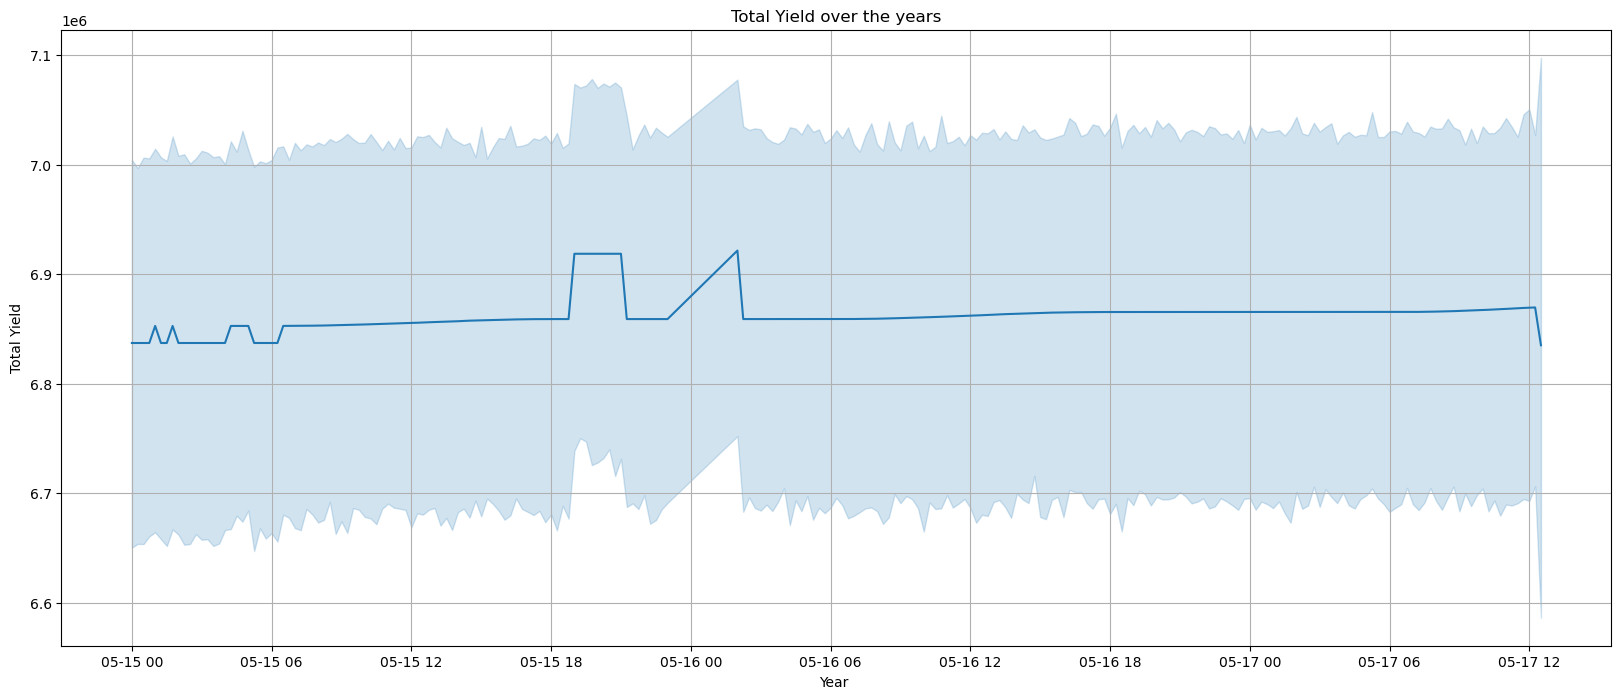

In [16]:
# Learning the trajectories of total yield 
fig = plt.figure(figsize=(20,8))
sns.lineplot(x='year',y = 'total_yield',data=df.head(5000))
plt.xlabel('Year ')
plt.ylabel('Total Yield')
plt.title('Total Yield over the years')
plt.grid()
plt.show()

In [17]:
# We can use the variance to explain whats happening in the above plot
total_yield =df['total_yield']
total_yield.describe() # The standard deviation is so small 

count    6.877800e+04
mean     6.978712e+06
std      4.162720e+05
min      6.183645e+06
25%      6.512003e+06
50%      7.146685e+06
75%      7.268706e+06
max      7.846821e+06
Name: total_yield, dtype: float64

In [18]:
df.columns

Index(['year', 'dc_power', 'ac_power', 'daily_yield', 'total_yield'], dtype='object')

# PART TWO : USING SCALED DATA : TEXT PREPROCESSING

In [19]:
scaler = MinMaxScaler()
X = df.drop(['year','total_yield'],axis=1).values
y = df['total_yield'].values.reshape(-1,1)
print(f"The shape of our labels is{X.shape}")
print(f"The shape of our target features is {y.shape}")

The shape of our labels is(68778, 3)
The shape of our target features is (68778, 1)


In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [22]:
X_train.shape,y_train.shape

((55022, 3), (55022, 1))

In [23]:
assert len(X_train) + len(X_test) == len(df)

# Linear Regression : MACHINE LEARNING

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_prediction  = lr.predict(X_test)
print(f"The Mean Absolute Error for Linear Model is {mean_absolute_error(y_test,lr_prediction)}")
print(f"The Mean Squared Error for Linear Model is {mean_squared_error(y_test,lr_prediction)}")

The Mean Absolute Error for Linear Model is 0.21749760831984863
The Mean Squared Error for Linear Model is 0.06264411555801154


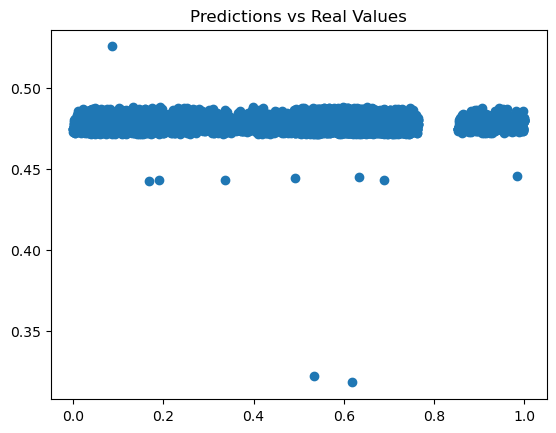

In [25]:
# plotting the residuals vs the real values
#fig = plt.figure(figsize=(15,8))
plt.scatter(y_test,lr_prediction)
plt.title('Predictions vs Real Values')
plt.show()

In [26]:
print(scaler.inverse_transform(lr_prediction))

[[6983626.16383617]
 [6973265.50365679]
 [6981328.79097381]
 ...
 [6969025.24606668]
 [6982036.54247728]
 [6973265.50365679]]


 # DEEP LEARNING LINEAR_REGRESSION

In [27]:
# We convert the numpy arrays into tensors
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [28]:
type(X_train)

torch.Tensor

In [29]:
X_train.shape,y_train.shape

(torch.Size([55022, 3]), torch.Size([55022, 1]))

In [30]:
# Creating our Model using Pytorch
class SolarYields(nn.Module):
    def __init__(self,input_dim=3,hidden_dim=27,output_dim=1,p=0.4):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        # Create 2 Linear layers and a dropout layer
        self.linear1 = nn.Linear(input_dim,hidden_dim)
        self.linear2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc = nn.Linear(hidden_dim,output_dim)
        self.dropout = nn.Dropout(p) # a dropout layer takes care of our overfitting problem
    def forward(self,x):
        x = self.linear1(x)
        #x = F.relu(x) # passing a linear activation function
        x = self.linear2(x)
        x = self.dropout(self.linear2(x))
        x = self.fc(x)
        return x

In [31]:
model = SolarYields()

In [32]:
scaler.inverse_transform(model.forward(X_train).detach().numpy())

array([[5830962. ],
       [5691675.5],
       [6039506.5],
       ...,
       [6075669.5],
       [5821058. ],
       [6127146.5]], dtype=float32)

In [33]:
from sklearn.metrics import accuracy_score

# Deep Linear Model Training

In [34]:
# Optimizer and Loss Function
optimizer = optim.SGD(model.parameters(),lr = 0.001)
criterion = nn.MSELoss()
#accuracy = accuracy_score()

In [35]:
epochs = 40
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    #train_accuracy = accuracy_score(y_pred.detach().numpy(),y_train.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = criterion(y_pred,y_test)
        #test_accuracy = accuracy_score(y_pred.detach().numpy(),y_test.detach().numpy())
        if epoch % 10 == 0:
            print(f"Epoch{epoch}|train loss{loss}||test loss{test_loss}")
        

Epoch0|train loss0.4428904950618744||test loss0.4284726083278656
Epoch10|train loss0.3961830139160156||test loss0.38178279995918274
Epoch20|train loss0.35361337661743164||test loss0.3411666750907898
Epoch30|train loss0.3192307651042938||test loss0.30573591589927673


In [36]:
torch.manual_seed(42)
deep_regression_preds = scaler.inverse_transform(model.forward(X_train).detach().numpy())
deep_regression_preds

array([[6165041. ],
       [6158538.5],
       [6219737.5],
       ...,
       [6230877.5],
       [6227834. ],
       [6233178.5]], dtype=float32)

In [37]:
deep_regression_preds.squeeze(1)

array([6165041. , 6158538.5, 6219737.5, ..., 6230877.5, 6227834. ,
       6233178.5], dtype=float32)

# LSTM : USING RNNS TO PREDICT THE FUTURE YIELD

In [38]:
class SolarLSTM(nn.Module):
    def __init__(self,input_dim=1,hidden_dim=64,n_layers=2,output_dim=1,p=0.4):
        super().__init__()
        #self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        #self.output_dim = output_dim
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_dim,hidden_dim,n_layers,dropout=p)
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_dim,output_dim)
    def forward(self,x:torch.Tensor):
        # instantiate the current and hidden cell states
        h0 = torch.zeros(self.n_layers,x.size(1),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.n_layers,x.size(1),self.hidden_dim).requires_grad_()
        output,(hn,cn) = self.rnn(x,(h0.detach().squeeze(1),c0.detach().squeeze(1)))
        output = self.fc(output)
        
        return output
        

In [39]:
lstm_model = SolarLSTM()

In [42]:
torch.manual_seed(42)
scaler.inverse_transform(lstm_model.forward(y_train).detach().numpy())

array([[5972119.5],
       [5972543. ],
       [5980515. ],
       ...,
       [5979801. ],
       [5976682.5],
       [5980307. ]], dtype=float32)

In [ ]:
# LSTM MODEL TRAINING
epochs =20
for epoch in range(epochs):
    lstm_model.train()
    y_pred = lstm_model(y_train)
    loss = criterion(y_pred,y_train)
    #train_accuracy = accuracy_score(y_pred.detach().numpy(),y_train.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lstm_model.eval()
    with torch.no_grad():
        y_pred = lstm_model(y_test)
        lstm_loss = criterion(y_pred,y_test)
        #test_accuracy = accuracy_score(y_pred.detach().numpy(),y_test.detach().numpy())
        if epoch % 10 == 0:
            print(f"Epoch{epoch}|train loss{loss}||test loss{lstm_loss}")
        